In [0]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0

     |████████████████████████████████| 71kB 2.3MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for cleverhans: filename=cleverhans-2.1.0-cp27-none-any.whl size=74866 sha256=5e322ba0edf4f90372a04cb0b9c88b42d15bd501dd01ea6a056e3a87586df6a3
  Stored in directory: /root/.cache/pip/wheels/5e/d5/ae/5bf57b9265bffd5783c4462a9a7c1c5fd0ebe51db83ff5f586
Successfully built cleverhans


In [0]:
#Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2

#Part 1: Training a target classifier

In [0]:
# Load data MNIST data and normalize to [0, 1]

(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = data_train/255.0
data_test = data_test/255.0

#Reshape training and testing data into 784-dimensional vectors 

data_train = np.array(data_train).reshape(60000,784)
data_test = np.array(data_test).reshape(10000,784)

#Convert integer labels for training and testing data into one-hot vectors 

labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.np_utils.to_categorical(labels_test, num_classes=10)



In [0]:
#Create classifier architecture, compile it, and train it

def classifier_model():
  model=Sequential()
  model.add(Dense(100,
                  activation='relu',
                  kernel_initializer='normal',
                  input_shape=(784,)))
  model.add(BatchNormalization())
  model.add(Dense(100,
                  activation='relu',
                  kernel_initializer='normal'))
  model.add(BatchNormalization())
  model.add(Dense(10,
                  activation='softmax'))
  return model

classifier_model=classifier_model()
classifier_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

classifier_model_data = classifier_model.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=256, shuffle=True)   

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 156us/step - loss: 0.3027 - acc: 0.9108 - val_loss: 0.1342 - val_acc: 0.9573
Epoch 2/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.1102 - acc: 0.9672 - val_loss: 0.1038 - val_acc: 0.9666
Epoch 3/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0750 - acc: 0.9780 - val_loss: 0.0922 - val_acc: 0.9709
Epoch 4/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0538 - acc: 0.9841 - val_loss: 0.0836 - val_acc: 0.9738
Epoch 5/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0404 - acc: 0.9878 - val_loss: 0.0786 - val_acc: 0.9762
Epoch 6/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.0320 - acc: 0.9908 - val_loss: 0.0782 - val_acc: 0.9751
Epoch 7/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.0263 - acc: 0.9920 - val_loss: 0.0859 - val_ac

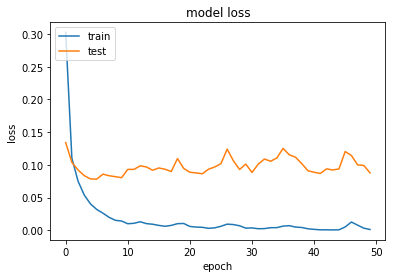

In [0]:
#Plot loss vs epoch
plt.plot(classifier_model_data.history['loss'])
plt.plot(classifier_model_data.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

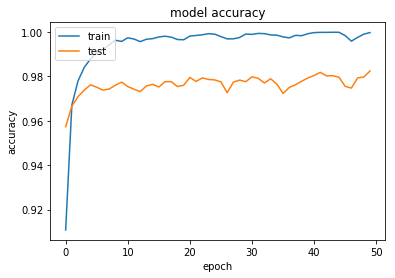

In [0]:
#Plot accuracy vs epoch
plt.plot(classifier_model_data.history['acc'])
plt.plot(classifier_model_data.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#Print accuracy of classifier on MNIST testing data
scores = classifier_model.evaluate(data_test,labels_test)
print("The accuracy of the model is: "+ str(scores[1]*100) +"%")

10000/10000 [==============================] - 1s 50us/step
The accuracy of the model is: 98.24000000000001%


In [0]:
# Edit the classifier name fed into KerasModel Wrapper with the name of the 
# classifier from above and then run this block

#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(classifier_model)

#Part 2: The Fast Gradient Method (FGM)

In [0]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1

fgsm=FastGradientMethod(wrap, sess=sess)
#Attack parameters
fgsm_params =  {'eps': 0.25, 'clip_min': 0.0, 'clip_max': 1.0}

#Generate adversarial data
fgsm_attack_data = fgsm.generate_np(data_test, **fgsm_params)

#Evaluate accuracy on target classifier 
scores = classifier_model.evaluate(fgsm_attack_data,labels_test)
print("The accuracy of the model with FGSM attack is: "+ str(scores[1]*100)+"%")

10000/10000 [==============================] - 5s 499us/step
The accuracy of the model with FGSM attack is: 8.07%


10 test sample images


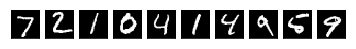

In [0]:
#Show ten original samples and their corresponding adversarial samples

print("10 test sample images")
n=10
plt.figure()
for i in range(n):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(data_test[i].reshape((28,28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


  
  

10 test fgsm attack sample images


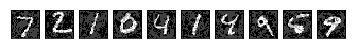

In [0]:
print("10 test fgsm attack sample images")
n=10
plt.figure()
for i in range(n):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(fgsm_attack_data[i].reshape((28,28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  

In [0]:
#Implementing Detection via Autoencoders

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer

ae = autoencoder()

ae.compile(loss='mse',
                 optimizer='adam',
                 metrics=['accuracy'])

ae_data = ae.fit(data_train, data_train, validation_data=(data_test, data_test), epochs=50, batch_size=256, shuffle=True)


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 15s 252us/step - loss: 0.0389 - acc: 0.0094 - val_loss: 0.0168 - val_acc: 0.0116
Epoch 2/50
60000/60000 [==============================] - 8s 140us/step - loss: 0.0127 - acc: 0.0107 - val_loss: 0.0096 - val_acc: 0.0137
Epoch 3/50
60000/60000 [==============================] - 8s 140us/step - loss: 0.0087 - acc: 0.0122 - val_loss: 0.0074 - val_acc: 0.0128
Epoch 4/50
60000/60000 [==============================] - 8s 141us/step - loss: 0.0071 - acc: 0.0123 - val_loss: 0.0062 - val_acc: 0.0113
Epoch 5/50
60000/60000 [==============================] - 8s 137us/step - loss: 0.0060 - acc: 0.0130 - val_loss: 0.0055 - val_acc: 0.0127
Epoch 6/50
60000/60000 [==============================] - 8s 141us/step - loss: 0.0053 - acc: 0.0134 - val_loss: 0.0049 - val_acc: 0.0140
Epoch 7/50
60000/60000 [==============================] - 8s 139us/step - loss: 0.0048 - acc: 0.0133 - val_loss: 0.0044 -

In [0]:
#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
data_train_attack = fgsm.generate_np(data_train, **fgsm_params)

# Obtain reconstruction errors on training set and determine a threshold 
reconstructed_images=ae.predict(data_train_attack)

error = keras.losses.mean_squared_error(data_train_attack, reconstructed_images)

# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error = error.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
threshold=np.min(error)

print('The threshold is: '+str(threshold))

# Calculate error of adversarial testing set

reconstructed_images_test=ae.predict(fgsm_attack_data)

error_test = keras.losses.mean_squared_error(fgsm_attack_data, reconstructed_images_test)
error_test = error_test.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
tp_count_test=0
for i in error_test:
  if i>threshold:
    tp_count_test+=1

# Print number of true positive samples
print('The number of true positives in test set are: '+str(tp_count_test))


# Determine false positives on benign testing set
#FILL THIS IN 

# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
fp_count_test=0
for i in error_test:
  if i<threshold:
    fp_count_test+=1

    
# Print number of false positive samples
#FILL THIS IN   

print('The number of false positives in test set are: '+str(fp_count_test))

The threshold is: 0.01934985
The number of true positives in test set are: 10000
The number of false positives in test set are: 0


#Part 3: Projected Gradient Descent

In [0]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

#Attack parameters
pgd_params =  {'eps': 0.25, 'eps_iter': 0.01, 'nb_iter':20, 'clip_min': 0.0, 'clip_max': 1.0}

#Generate adversarial data
pgd_attack_data=pgd.generate_np(data_test,**pgd_params)

#Evaluate accuracy of perturbed data on target classifier

scores = classifier_model.evaluate(pgd_attack_data,labels_test)
print("The accuracy of the model with PGD attack is: "+ str(scores[1]*100)+"%")

10000/10000 [==============================] - 7s 672us/step
The accuracy of the model with PGD attack is: 0.67%


10 test sample images


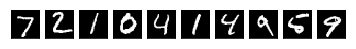

In [0]:
#Show ten original samples and their corresponding adversarial samples

print("10 test sample images")
n=10
plt.figure()
for i in range(n):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(data_test[i].reshape((28,28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


  
  

10 test pgd attack sample images


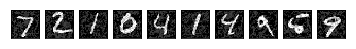

In [0]:
#Show ten original samples and their corresponding adversarial samples
print("10 test pgd attack sample images")
n=10
plt.figure()
for i in range(n):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(pgd_attack_data[i].reshape((28,28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [0]:
#Implementing the adversarial training defense
data_train_attack=pgd.generate_np(data_train, **pgd_params)
adv_model=keras.models.clone_model(classifier_model)
adv_model.build()
adv_model.set_weights(classifier_model.get_weights())
adv_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

adv_model_data = adv_model.fit(data_train_attack, labels_train, validation_data=(data_test, labels_test), epochs=50, batch_size=256, shuffle=True)   

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 184us/step - loss: 2.4119 - acc: 0.7355 - val_loss: 0.7749 - val_acc: 0.8685
Epoch 2/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.1439 - acc: 0.9654 - val_loss: 0.6827 - val_acc: 0.8715
Epoch 3/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.0588 - acc: 0.9847 - val_loss: 0.6882 - val_acc: 0.8683
Epoch 4/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.0314 - acc: 0.9919 - val_loss: 0.6634 - val_acc: 0.8674
Epoch 5/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.0183 - acc: 0.9957 - val_loss: 0.6437 - val_acc: 0.8705
Epoch 6/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.0122 - acc: 0.9974 - val_loss: 0.6352 - val_acc: 0.8662
Epoch 7/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.0078 - acc: 0.9986 - val_loss: 0.6849 - val_a

In [0]:
#Using the defense to evaluate the accuracy of the perturbed data
scores = adv_model.evaluate(data_test,labels_test)
print("The accuracy of the model with adversarial training is: "+str(scores[1]*100)+"%")

10000/10000 [==============================] - 1s 56us/step
The accuracy of the model with adversarial training is: 82.95%


#Part 4: Carlini and Wagner Attack

In [0]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
cw = CarliniWagnerL2(wrap, sess=sess)

#Attack parameters
cw_params =  {'binary_search_steps': 1, 'y':None, 'learning_rate': 1.25, 'batch_size':16, 'initial_const':10, 'clip_min': 0.0, 'clip_max': 1.0}

#Generate adversarial data
cw_attack_data = cw.generate_np(data_test,**cw_params)

#Evaluate accuracy of perturbed data on target classifier
scores = classifier_model.evaluate(cw_attack_data,labels_test)
print("The accuracy of the model with CW attack is: "+ str(scores[1]*100)+"%")

10000/10000 [==============================] - 7s 683us/step
The accuracy of the model with CW attack is: 1.26%


10 test sample images


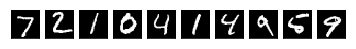

In [0]:
#Show ten original samples and their corresponding adversarial samples

print("10 test sample images")
n=10
plt.figure()
for i in range(n):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(data_test[i].reshape((28,28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

10 test cw attack sample images


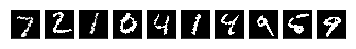

In [0]:
print("10 test cw attack sample images")
n=10
plt.figure()
for i in range(n):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(cw_attack_data[i].reshape((28,28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [0]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
pca_train = pca.transform(data_train)
pca_test = pca.transform(data_test)

#Transform perturbed CW data using the subspace from the original training data

pca_cw_attack=pca.transform(cw_attack_data)

# create model for PCA
def pca_model():
    model = Sequential()
    
    #FILL THIS IN 
    model.add(Dense(100,
                    activation='relu',
                    kernel_initializer='normal',
                    input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(Dense(100,
                  activation='relu',
                  kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(10,
                  activation='softmax'))

    return model

#Create model graph, compile it, and train it using pca_train lables_train 

pca_model=pca_model()
pca_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

pca_model_data = pca_model.fit(pca_train, labels_train, validation_data=(pca_test, labels_test), epochs=50, batch_size=256, shuffle=True)   

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 178us/step - loss: 0.3475 - acc: 0.8971 - val_loss: 0.1430 - val_acc: 0.9572
Epoch 2/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1157 - acc: 0.9668 - val_loss: 0.1022 - val_acc: 0.9706
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0770 - acc: 0.9777 - val_loss: 0.0856 - val_acc: 0.9746
Epoch 4/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0569 - acc: 0.9837 - val_loss: 0.0793 - val_acc: 0.9765
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0429 - acc: 0.9876 - val_loss: 0.0749 - val_acc: 0.9778
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0347 - acc: 0.9899 - val_loss: 0.0749 - val_acc: 0.9775
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0275 - acc: 0.9924 - val_loss: 0.0754 - val_a

In [0]:
#Using the defense (and comparing to baseline accuracy)

scores = pca_model.evaluate(pca_cw_attack,labels_test)
print("The accuracy of the model with PCA is: "+ str(scores[1]*100)+"%")

10000/10000 [==============================] - 0s 50us/step
The accuracy of the model with PCA is: 85.55%


#Part 5: DeepFool 

In [0]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
df = DeepFool(wrap, sess=sess)

#Attack parameters
df_params =  {'nb_candidate': 10, 'max_iter': 50, 'clip_min': 0.0, 'clip_max': 1.0}

#Generate adversarial data
df_attack_data = df.generate_np(data_test,**cw_params)

#Evaluate accuracy of perturbed data on target classifier
scores = classifier_model.evaluate(df_attack_data,labels_test)
print("The accuracy of the model with Deep Fool attack is: "+ str(scores[1]*100)+"%")

10000/10000 [==============================] - 7s 687us/step
The accuracy of the model with Deep Fool attack is: 1.29%


10 test sample images


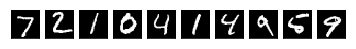

In [0]:
#Show ten original samples and their corresponding adversarial samples

print("10 test sample images")
n=10
plt.figure()
for i in range(n):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(data_test[i].reshape((28,28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

10 test deep fool attack images


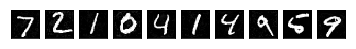

In [0]:
print("10 test deep fool attack images")
n=10
plt.figure()
for i in range(n):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(df_attack_data[i].reshape((28,28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [0]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
df_attack_data_train = df.generate_np(data_train, **df_params)
data_total_train = np.concatenate([df_attack_data_train, data_train])

#Create and train DAE graph

dae_model = autoencoder()

dae_model.compile(loss='mse',
                 optimizer='adam',
                 metrics=['accuracy'])

dae_data = dae_model.fit(data_total_train, data_total_train, validation_data=(df_attack_data, df_attack_data), epochs=50, batch_size=256, shuffle=True)


Train on 120000 samples, validate on 10000 samples
Epoch 1/50
120000/120000 [==============================] - 30s 247us/step - loss: 0.0256 - acc: 0.0095 - val_loss: 0.0099 - val_acc: 0.0107
Epoch 2/50
120000/120000 [==============================] - 21s 174us/step - loss: 0.0081 - acc: 0.0122 - val_loss: 0.0066 - val_acc: 0.0125
Epoch 3/50
120000/120000 [==============================] - 19s 160us/step - loss: 0.0058 - acc: 0.0135 - val_loss: 0.0052 - val_acc: 0.0140
Epoch 4/50
120000/120000 [==============================] - 19s 161us/step - loss: 0.0047 - acc: 0.0138 - val_loss: 0.0045 - val_acc: 0.0132
Epoch 5/50
120000/120000 [==============================] - 19s 158us/step - loss: 0.0040 - acc: 0.0143 - val_loss: 0.0039 - val_acc: 0.0143
Epoch 6/50
120000/120000 [==============================] - 19s 162us/step - loss: 0.0036 - acc: 0.0147 - val_loss: 0.0036 - val_acc: 0.0162
Epoch 7/50
120000/120000 [==============================] - 20s 166us/step - loss: 0.0033 - acc: 0.0154

In [0]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
reconstructed_images_dae=dae_model.predict(df_attack_data)

#Evaluate accuracy of FGM samples after denoising 

scores = classifier_model.evaluate(reconstructed_images_dae,labels_test)
print("The accuracy of the model after removing Deep Fool perturbation is: "+ str(scores[1]*100) +"%")

10000/10000 [==============================] - 1s 54us/step
The accuracy of the model after removing Deep Fool perturbation is: 97.8%


10 test denoised images


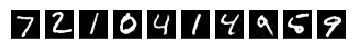

In [0]:
#Show ten samples of adversarial samples after denoising

print("10 test denoised images")
n=10
plt.figure()
for i in range(n):
  ax=plt.subplot(2,10,i+1)
  plt.imshow(reconstructed_images_dae[i].reshape((28,28)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)